# Classificação Ridge

## Resumo dos resultados dessa etapa

O modelo Ridge foi ajustado aos dados.

Após o refinamento dos hiperparâmetros, a acurácia média atingida pelo modelo ridge foi de 73%.

## Breve explicação e referências sobre o método

## Detalhamento da etapa

### Imports

In [12]:
import requests
from io import BytesIO
import joblib
import numpy as np


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import classification_report

from random import seed, choice

import lime
import lime.lime_tabular

import eli5
import shap
shap.initjs()

In [2]:
def load_remote_joblib(url):
    """função utilizada para carregar joblib de fonte remota
    ESSAfeature_namesCAO É PERIGOSA
    a função joblib.load pode executar código arbitrário durante sua execuççao
    não utilize essa parte do código se você não tiver certeza do que está fazendo
    """
    content = requests.get(url).content
    return joblib.load(BytesIO(content))
    

x_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/x_scaler.joblib")
scaled_X = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_X.joblib")

y_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/y_scaler.joblib")
scaled_y = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_y.joblib")

feature_names = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/features.joblib")
categories = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/categories.joblib")

### Tunning

In [3]:
ridge = RidgeClassifier(random_state=42)

In [4]:
ridge_params = {
    'alpha':np.arange(0.1, 10.1, 0.1),
    'fit_intercept':[True, False],
    'tol': [1/10**(i) for i in np.arange(3, 6)]
}

In [5]:
ridge_gs = GridSearchCV(ridge, ridge_params, n_jobs=-1, cv=4)

In [6]:
ridge_gs.fit(scaled_X, scaled_y.ravel())

GridSearchCV(cv=4, estimator=RidgeClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
                         'fit_intercept': [True, False],
                         'tol': [0.001, 0.0001, 1e-05]})

## Modelo

In [7]:
ridge_model = ridge_gs.best_estimator_

In [8]:
ridge_model.get_params()

{'alpha': 9.8,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

## Performance

In [9]:
print(
    classification_report(
        scaled_y,
        ridge_model.predict(scaled_X),
        target_names=categories
    ))

              precision    recall  f1-score   support

   gini_alto       0.74      0.71      0.73      2779
  gini_baixo       0.72      0.76      0.74      2781

    accuracy                           0.73      5560
   macro avg       0.73      0.73      0.73      5560
weighted avg       0.73      0.73      0.73      5560



In [10]:
joblib.dump(ridge_model, 'data_gini/ridge_model.joblib')

['data_gini/ridge_model.joblib']

## Interpretabilidade

Sorteio de uma observação para ser utilizada nos algorítimos de interpretabilidade

In [13]:
seed(42)

random_obs_idx = choice(range(len(scaled_X)))

In [14]:
random_obs = scaled_X[random_obs_idx]

### ELI5

In [15]:
eli5.show_weights(ridge_model, feature_names=feature_names)

Weight?,Feature
+0.788,Assistência Técnica (%)
+0.552,Rendimento-Cana (kg/ha)
+0.478,Bovinos-Leite(%)
+0.477,Uso das terras-Lavoura(%)
+0.328,Produtor com escolaridade até Ensino Fundamental(%)
+0.315,Rendimento-Uva(kg/ha)
+0.234,Utilização de Agrotóxicos (%)
+0.223,Bovinos-Corte (%)
+0.223,Rendimento-Laranja(kg/ha)
+0.194,Rendimento-Milho (kg/ha)


In [16]:
eli5.explain_prediction_sklearn(ridge_model, random_obs,feature_names=feature_names)

Explanation(estimator='RidgeClassifier(alpha=9.8, fit_intercept=False, random_state=42)', description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='Estabelecimento Agropecuário (N)', weight=0.38886369737220605, std=None, value=0.212739545348747), FeatureWeight(feature='Atividade-Lavoura Temporária (%)', weight=0.3661702306037784, std=None, value=0.45258899999999996), FeatureWeight(feature='Agricultura familiar (%)', weight=0.2538932532381101, std=None, value=0.884756), FeatureWeight(feature='Atividade-Pesca(%)', weight=0.1691850980786332, std=None, value=0.3131479604188101), FeatureWeight(feature='Aves-Corte (%)', weight=0.07688330458841947, std=None, value=0.18482158664400541), FeatureWeight(feature='Aves-Ovos(%)', weight=0.05398304813391798, std=None, value=0.3228215002440744), FeatureWeight(feature='Atividade-Pecuária(%)', weight=0.05027787112721009, std=None, value=0.296499), FeatureWeight(feature='Uso das terras-Pastagem (%)', weight=0.04499549572700073, std=None, value=0.49576040250063347), FeatureWeight(feature='Área lavoura/ Trator(ha)', weight=0.030960358968381067, std=None, value=0.0547546573780609), FeatureWeight(feature='Uso de irrigação (%)', weight=0.030710099148497202, std=None, value=0.185766), FeatureWeight(feature='Rendimento-Arroz (kg/ha)', weight=0.02661626734815213, std=None, value=0.14166666666666666), FeatureWeight(feature='Área lavoura/ Adubadeira (ha)', weight=0.020876476133102555, std=None, value=0.07784887220707483), FeatureWeight(feature='Despesa com Agrotóxicos (%)', weight=0.010562989665845682, std=None, value=0.010314338355147341), FeatureWeight(feature='Atividade-Lavoura Permanente(%)', weight=0.010184834710012112, std=None, value=0.0616338), FeatureWeight(feature='Área lavoura/ Semeadeira(ha)', weight=0.007839530234263769, std=None, value=0.08698540437670874), FeatureWeight(feature='Área média (ha)', weight=0.005580101340156889, std=None, value=0.007785414838646778), FeatureWeight(feature='Pessoal Ocupado / Estabelecimento (Pessoa)', weight=0.004071398146998905, std=None, value=0.01993800254985801), FeatureWeight(feature='Carga de Bovinos (n/ha)', weight=0.00011918693174395918, std=None, value=0.0011430760026614629), FeatureWeight(feature='Atividade-Aquicultura(%)', weight=5.7752725822645265e-05, std=None, value=0.0007293950000000001), FeatureWeight(feature='Rendimento-Cacau(kg/ha)', weight=4.1630972931272636e-05, std=None, value=0.0008910328947368423)], neg=[FeatureWeight(feature='Produtor com escolaridade até Ensino Fundamental(%)', weight=-0.20952276909386586, std=None, value=0.63895), FeatureWeight(feature='Assistência Técnica (%)', weight=-0.07703468232116475, std=None, value=0.0977389), FeatureWeight(feature='Bovinos-Leite(%)', weight=-0.07663526890479207, std=None, value=0.1603336981211458), FeatureWeight(feature='Utilização de Agrotóxicos (%)', weight=-0.04612147088468338, std=None, value=0.19671500000000003), FeatureWeight(feature='Rendimento-Mandioca (kg/ha)', weight=-0.04233088894899745, std=None, value=0.22518133333333334), FeatureWeight(feature='Bovinos-Corte (%)', weight=-0.03514521029556608, std=None, value=0.157549), FeatureWeight(feature='Uso das terras-Lavoura(%)', weight=-0.025000380221093937, std=None, value=0.05240028614352984), FeatureWeight(feature='Rendimento-Milho (kg/ha)', weight=-0.017634369915427366, std=None, value=0.09081464968152865), FeatureWeight(feature='Atividade-Produção Florestal(%)', weight=-0.013297435103031479, std=None, value=0.08816538148676917), FeatureWeight(feature='Rendimento-Cana (kg/ha)', weight=-0.0078302726831088, std=None, value=0.014194350000000001), FeatureWeight(feature='Rendimento-Laranja(kg/ha)', weight=-0.003899505838227951, std=None, value=0.017484), FeatureWeight(feature='Rendimento-Café(kg/ha)', weight=-0.0010888174629914793, std=None, value=0.01388888888888889), FeatureWeight(feature='Atividade-Horticultura&Floricultura(%)

### LIME

### SHAP

In [18]:
shap_ridge_expainer = shap.KernelExplainer(
    ridge_model.predict,
    shap.sample(scaled_X, random_state=42)
)

In [19]:
shap_ridge_values = shap_ridge_expainer.shap_values(shap.sample(scaled_X, random_state=42))

  0%|          | 0/100 [00:00<?, ?it/s]

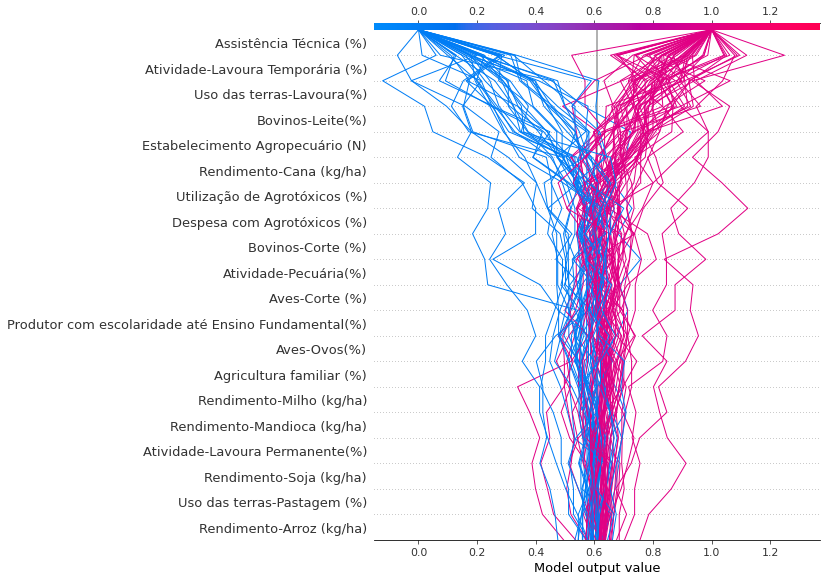

In [21]:
shap.decision_plot(
    shap_ridge_expainer.expected_value,
    shap_ridge_values,
    feature_names=feature_names
)

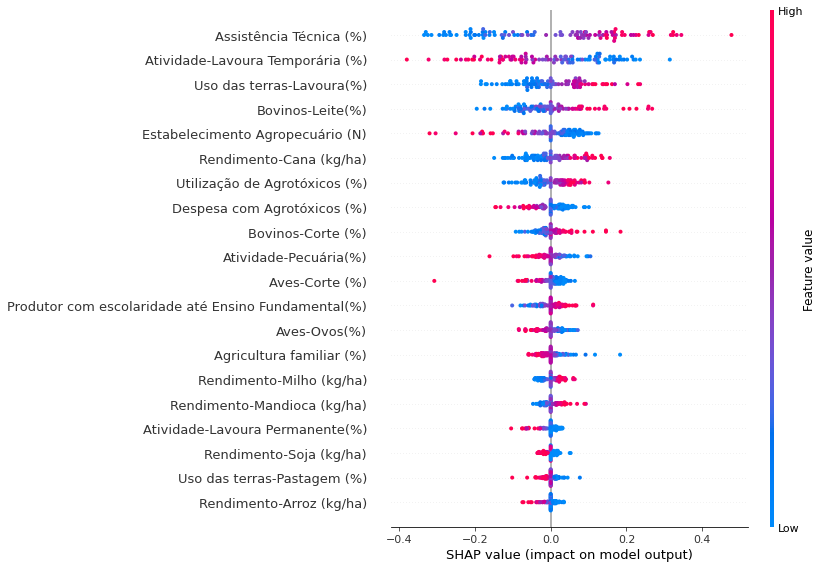

In [22]:
shap.summary_plot(
    shap_ridge_values,
    features=shap.sample(scaled_X, random_state=42),
    feature_names=feature_names
)